In [1]:
import os
import sys
sys.path.append("../../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets.unibo_powertools_data import UniboPowertoolsData, CycleCols
from datasets.model_data_handler import ModelDataHandler
from datasets.prepare_rul_data import RulHandler

In [2]:
# 读取数据集
data_root_path = "/home/lxh/battery_phm/data/raw_data/unibo/"

dataset = UniboPowertoolsData(
    test_types=[],
    chunk_size=1000000,
    lines=[37, 40],
    charge_line=37,
    discharge_line=40,
    base_path=data_root_path
)

train_names = [
    '000-DM-3.0-4019-S',#minimum capacity 1.48
    '001-DM-3.0-4019-S',#minimum capacity 1.81
    '002-DM-3.0-4019-S',#minimum capacity 2.06
    '009-DM-3.0-4019-H',#minimum capacity 1.41
    '010-DM-3.0-4019-H',#minimum capacity 1.44
    '014-DM-3.0-4019-P',#minimum capacity 1.7
    '015-DM-3.0-4019-P',#minimum capacity 1.76
    '016-DM-3.0-4019-P',#minimum capacity 1.56
    '017-DM-3.0-4019-P',#minimum capacity 1.29
    #'047-DM-3.0-4019-P',#new 1.98
    #'049-DM-3.0-4019-P',#new 2.19
    '007-EE-2.85-0820-S',#2.5
    '008-EE-2.85-0820-S',#2.49
    '042-EE-2.85-0820-S',#2.51
    '043-EE-2.85-0820-H',#2.31
    '018-DP-2.00-1320-S',#minimum capacity 1.82
    #'019-DP-2.00-1320-S',#minimum capacity 1.61
    '036-DP-2.00-1720-S',#minimum capacity 1.91
    '037-DP-2.00-1720-S',#minimum capacity 1.84
    '038-DP-2.00-2420-S',#minimum capacity 1.854 (to 0)
    '050-DP-2.00-4020-S',#new 1.81
    '051-DP-2.00-4020-S',#new 1.866
    '040-DM-4.00-2320-S',#minimum capacity 3.75, cycles 188
]

test_names = [
    '003-DM-3.0-4019-S',#minimum capacity 1.84
    '011-DM-3.0-4019-H',#minimum capacity 1.36
    '013-DM-3.0-4019-P',#minimum capacity 1.6
    '006-EE-2.85-0820-S',# 2.621
    '044-EE-2.85-0820-H',# 2.43
    '039-DP-2.00-2420-S',#minimum capacity 1.93
    '041-DM-4.00-2320-S',#minimum capacity 3.76, cycles 190
]

dataset.prepare_data(train_names, test_names)
dataset_handler = ModelDataHandler(dataset, [
    CycleCols.VOLTAGE,
    CycleCols.CURRENT,
    CycleCols.TEMPERATURE
])

rul_handler = RulHandler()

In [3]:
# 数据准备
CAPACITY_THRESHOLDS = {
  3.0 : 2.7, #th 90% - min 2.1, 70%
  2.85 : 2.7, #th 94.7% - min 2.622, 92%
  2.0 : 1.93, #th 96.5% - min 1.93, 96.5%
  4.0 : 3.77, #th 94.2% - min 3.77 94.2%
  4.9 : 4.7, #th 95.9% - min 4.3, 87.7%
  5.0 : 4.5 #th 90% - min 3.63, 72.6%
}
N_CYCLE = 500
WARMUP_TRAIN = 15
WARMUP_TEST = 30

(train_x, train_y_soh, test_x, test_y_soh,
  train_battery_range, test_battery_range,
  time_train, time_test, current_train, current_test) = dataset_handler.get_discharge_whole_cycle_future(train_names, test_names)

train_y = rul_handler.prepare_y_future(train_names, train_battery_range, train_y_soh, current_train, time_train, CAPACITY_THRESHOLDS)
del globals()["current_train"]
del globals()["time_train"]
test_y = rul_handler.prepare_y_future(test_names, test_battery_range, test_y_soh, current_test, time_test, CAPACITY_THRESHOLDS)
del globals()["current_test"]
del globals()["time_test"]
train_x, test_x = rul_handler.compress_cycle(train_x, test_x)


x_norm = rul_handler.Normalization()
train_x, test_x = x_norm.fit_and_normalize(train_x, test_x)
train_x = rul_handler.battery_life_to_time_series(train_x, N_CYCLE, train_battery_range)
test_x = rul_handler.battery_life_to_time_series(test_x, N_CYCLE, test_battery_range)

train_x, train_y, train_battery_range, train_y_soh = rul_handler.delete_initial(train_x, train_y, train_battery_range, train_y_soh, WARMUP_TRAIN)
test_x, test_y, test_battery_range, test_y_soh = rul_handler.delete_initial(test_x, test_y, test_battery_range, test_y_soh, WARMUP_TEST)

# first one is SOH, we keep only RUL
train_y = train_y[:,1]
test_y = test_y[:,1]

# 对y进行归一化
y_norm = rul_handler.Normalization()
train_y, test_y = y_norm.fit_and_normalize(train_y, test_y)

/home/lxh/battery_phm/notebooks/data_preprocess/../../datasets/model_data_handler.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(


[338, 691, 1009, 1493, 1960, 2268, 2566, 2875, 3200, 4185, 5170, 6155, 7140, 8125, 8654, 9177, 9736, 10324, 10912, 11025]
107003


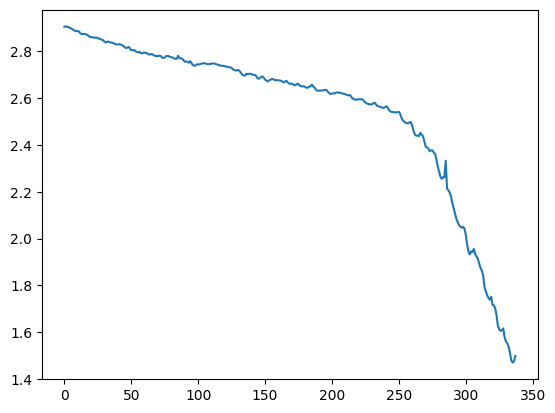

In [15]:
print(train_battery_range)
print(sum(train_battery_range))
a = 0
for b in train_battery_range:
    # print(train_y_soh[a:b])
    plt.plot(train_y_soh[a:b])
    a = b
    break